# Mathematical exercises

**Exercise 1** (3 points): Problem 9.4 in the PRML textbook. Suppose we wish to use the EM algorithm to maximize the posterior distribution over parameters $p(\theta|X)$ for a model containing latent variables, where $X$ is the observed data set. Show that the E step remains the same as in the maximum likelihood case, whereas in the M step the quantity to be maximized is given by $Q(\theta, \theta_{old}) + ln p(\theta)$ where $Q(\theta, \theta_{old})$ is defined by (9.30).
From Bayes' Theorem the posterior distribution over parameters can be written as: $p(\theta|X) \propto p(X|\theta)p(\theta)$. In order to use (9.29) take the logarithm of both sides and substitute (9.29) in for the log likelihood.
$$
ln(p(\theta|X)) \propto ln(p(X|\theta)) + ln(p(\theta)) = ln\left\{\sum_{Z}p(X, Z|\theta)\right\} + ln(p(\theta)) = ln\left\{\sum_{Z}p(X, Z|\theta)p(\theta))\right\}
$$
We see that the E step still must maximize $p(X, Z|\theta_{old})$. Now from (9.30) we see that the only change to this equation will be that the term $p(X,Z|\theta)$ will be replaced by $p(X,Z|\theta)p(\theta)$. So now we have:
$$
Q(\theta, \theta_{old}) = \sum_{Z}p(Z|X, \theta_{old})ln(p(X,Z|\theta)p(\theta))
$$
Expanding and distributing:
$$
Q(\theta, \theta_{old}) = \sum_{Z}p(Z|X, \theta_{old})ln(p(X,Z|\theta)) + ln(p(\theta))\sum_{Z}p(Z|X, \theta_{old})
$$
$$
Q(\theta, \theta_{old}) = Q(\theta, \theta_{old})_{9.30} +ln(p(\theta)) \sum_{Z}p(Z|X, \theta_{old})
$$
Now $\sum_{Z}p(Z|X, \theta_{old}) = 1$ since for a given latent variable $Z$, $p(Z|X, \theta_{old})$ is the proportion of data that belongs to this latent variable class. Summing over all latent variables $Z$ would result in a total proportion of 1. Therefore we no have:
$$
Q(\theta, \theta_{old}) = Q(\theta, \theta_{old})_{9.30} + ln(p(\theta))
$$

**Exercise 2**: (3 points): Problem 9.14 in the PRML textbook. Consider the joint distribution of latent and observed variables for the Bernoulli distribution obtained by forming the product of $p(x|z, \mu)$ given by (9.52) and $p(z|\pi)$ given by (9.53). Show that if we marginalize this joint distribution with respect to $z$, then we obtain (9.47).

$$
p(x|z,\mu) = \prod_{k=1}^{K}p(x|\mu_{k})^{z_{k}}
$$

$$
p(z|\pi) = \prod_{k=1}^{K}\pi_{k}^{z_{k}}
$$

$$
p(x, z|\pi,\mu) = \prod_{k=1}^{K}p(x|\mu_{k})^{z_{k}}\pi_{k}^{z_{k}}
$$
Marginalizing over $z$

$$
p(x|\mu, \pi) = \sum_{z}p(x, z|\pi,\mu) = \sum_{z}\prod_{k=1}^{K}p(x|\mu_{k})^{z_{k}}\pi_{k}^{z_{k}}
$$
Because $z_{k} = 1$ for only the kth term of the summation over z, the sum of products reduces to:
$$
p(x|\mu, \pi) = \sum_{z}p(x, z|\pi,\mu) = \pi_{1}p(x|\mu_{1}) + ... + \pi_{K}p(x|\mu_{K}) = \sum_{k=1}^{K}\pi_{k}p(x|\mu_{k})
$$

# Coding exercises

In the exercises below, we will implement the expectation maximization (EM) algorithm, applying it to a mixture of Gaussians model to describe clustering in data.

Reminder: Once your notebook is complete, you should restart the kernel, run all of the cells in order, and make sure that no errors occur. Notebooks that run successfully without errors will be awarded one extra credit point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Mixture model for synthetic data

To begin, we'll generate some synthetic data from a mixture of Gaussians model. Each data point is generated from one of two multimodal Gaussian distributions, but the points aren't given any labels.

Text(0, 0.5, 'x2')

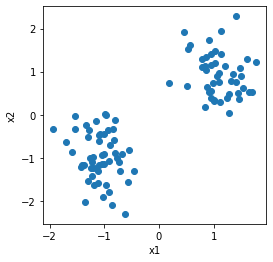

In [2]:
# Make some fake data.
np.random.seed(15)
d = 2  # dimensionality of data
n = 100  # total number of data points

# Generate means (we'll use underscores to denote the true parameters, which we'll try to infer below):
mu1_ = np.ones(d)
mu2_ = -np.ones(d)

# Generate covariance matrices as linear combinations of outer products of basis vectors:
vecs = np.random.randn(d,d)
Sigma1_ = np.sum([(0.5+np.random.rand())*np.outer(vecs[i], vecs[i]) for i in range(d)], axis=0)
Sigma2_ = np.sum([(0.5+np.random.rand())*np.outer(vecs[i], vecs[i]) for i in range(d)], axis=0)

# The mixture probabilities:
pi1_, pi2_ = 0.4, 0.6 

# For each data point, choose a cluster that it belongs to and generate its location:
x = np.zeros((0,d))
labels = []  # we won't use cluster labels for fitting, but we'll use it to check the model below
for ii in range(n):
    if np.random.rand() < pi1_:
        x = np.vstack((x, np.random.multivariate_normal(mu1_, Sigma1_)))
        labels.append(0)
    else:
        x = np.vstack((x, np.random.multivariate_normal(mu2_, Sigma2_)))
        labels.append(1)

# Plot the data:
plt.figure(figsize=(4,4))
plt.plot(x[:,0], x[:,1], 'o')
plt.xlabel('x1')
plt.ylabel('x2')

**Exercise 1** (5 points): Implement the EM algorithm to find the maximum likelihood solution for a mixture of Gaussians model with $K=2$ applied to the data above. Report the inferred values of the means and mixture probabilities. Plot the value of the log likelihood at each step in the iteration and show that it converges. Finally, plot the data on top of a contour plot illustrating the expected distribution under the fitted model. The algorithm should be implemented from scratch, with only basic Numpy functions being used.

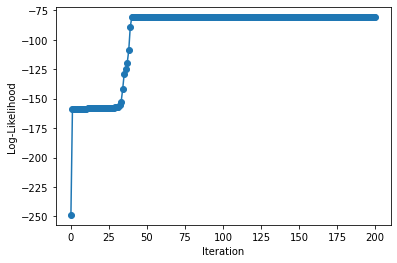

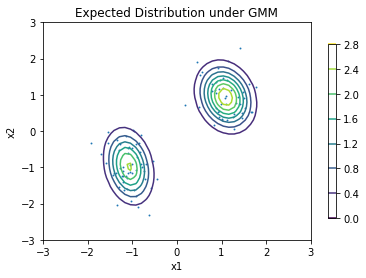

In [3]:
## Solution ##
### K means model ###
class GMM():
    def __init__(self, K, n_iter):
        self.K = K #number of components
        self.n_iter = n_iter
    
    def normal(self, x, mu, sigma):
        '''Calculate the probability of x given mu and sigma
        x: vector of length 2
        mu: vector of length 2
        sigma: 2x2 matrix'''
        prefactor = 1/(2*np.pi*np.linalg.det(sigma))**(1/2)
        e = np.exp((-1/2)*(x-mu).T @ np.linalg.inv(sigma) @ (x-mu))
        norm = prefactor*e
        return norm

    def random_split(self, X):
        splits = []
        A = np.copy(X)
        for k in range(self.K - 1):
            choice = np.random.choice(range(A.shape[0]), size=(int(A.shape[0]/self.K),), replace=False)    
            ind = np.zeros(A.shape[0], dtype=bool)
            ind[choice] = True
            splits.append(A[ind])

            rest = ~ind
            A = A[rest]

            splits.append(A)#add the last split of the left over samples

        return splits

    def log_likelihood(self, X):
        return np.sum([np.log(np.sum([self.pi[k] * self.normal(X[n, :], self.mu[k,:], self.sigma[k]) for k in range(self.K)])) for n in range(X.shape[0])])

    def fit(self, X, plot=True, init=None):
        '''
        Implement the EM algorithm for gaussian mixture on data X
        '''
        n_samples, n_features = np.shape(X)
        # Initial guesses of pis, mus, covs:
        # self.pi = [init_splits[k].shape[0]/n_samples for k in range(self.K)]
        self.pi = np.array([1/self.K for _ in range(self.K)])
        # self.mu = [np.mean(init_splits[k], axis=0) for k in range(self.K)]
        self.mu = X[np.random.choice(n_samples, self.K), :]# mu is an array of shape n-by-K
        # self.sigma = [np.cov(X.T) for k in range(self.K)]
        self.sigma = [np.cov(X.T) for _ in range(self.K)]
        
        # The GMM EM algorithm:
        LL = self.log_likelihood(X)
        losses = [LL]
        for i in range(self.n_iter):
            # E STEP
            # responsibilities
            self.gamma = np.random.rand(n_samples, self.K) # initial gamma values, responsibilities
            for n in range(n_samples):
                numer = [self.pi[k] * self.normal(X[n, :], self.mu[k, :], self.sigma[k]) for k in range(self.K)]
                denom = sum(numer)
                self.gamma[n, :] = np.array([numer[k]/denom for k in range(self.K)])

            Nk = np.sum(self.gamma, axis=0)

            # M STEP
            # calculate new mean vector
            mu_temp = np.zeros([n_features,self.K])
            for k in range(self.K):
                mu_temp = np.sum([self.gamma[n, k] * X[n, :] for n in range(n_samples)], axis=0)
                self.mu[k, :] = mu_temp/Nk[k]

            # calcuate covariance matricies
            cov_temp = np.zeros([n_features,n_features])
            for k in range(self.K):
                cov_temp = np.sum(np.array([self.gamma[n, k]* (X[n, :] - self.mu[k, :]).reshape(-1,1) @ (X[n, :] - self.mu[k, :]).reshape(-1,1).T for n in range(n_samples)]), axis=0)
                self.sigma[k] = cov_temp/Nk[k]

            # calculate pi
            self.pi = np.array([Nk[k]/n_samples for k in range(self.K)])

            LL = self.log_likelihood(X)
            losses.append(LL)
            
        if plot:
            # Plot the loss function:
            plt.plot(range(self.n_iter+1), losses, '-o')
            plt.xlabel('Iteration')
            plt.ylabel('Log-Likelihood')
            plt.show()

    def score_samples(self, X):
        likelihood = np.zeros((len(X), self.K))
        for n in range(X.shape[0]):
            for k in range(self.K):
                likelihood[n, k] = self.normal(X[n], self.mu[k,:], self.sigma[k])#self.pi[k] * 

        return likelihood

K = 2
gm_model = GMM(K=K, n_iter=200)

gm_model.fit(x, plot=True)

# display predicted scores by the model as a contour plot

XX, YY = np.meshgrid(np.linspace(-3.0, 3.0), np.linspace(-3.0, 3.0))
grid = np.array([XX.ravel(), YY.ravel()]).T
ZZ = gm_model.score_samples(grid)

CS1 = plt.contour(XX, YY, ZZ[:,0].reshape(XX.shape))
CS2 = plt.contour(XX, YY, ZZ[:,1].reshape(XX.shape))
CB = plt.colorbar(CS1, shrink=0.8, extend="both")
plt.scatter(x[:, 0], x[:, 1], 0.8)
plt.title("Expected Distribution under GMM")
plt.axis("tight")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

**Exercise 2** (3 points): Now fit the same data the easy way using `GaussianMixture` from the `sklearn` library. Report the estimated mean vectors and mixture probabilities, as well as the fraction of cluster labels that are correctly predicted by the model by comparing the model's predicted cluster labels with the vector `labels` that we defined above.

In [5]:
from sklearn.mixture import GaussianMixture
## Solution ##

gm = GaussianMixture(n_components=2, random_state=0).fit(x)
preds = gm.predict(x)

score = 0
for i in range(len(preds)):
    if preds[i] == labels[i]:
        score += 1
acc = score/len(preds)
labels_inv = np.ones(len(labels)) - labels
for i in range(len(preds)):
    if preds[i] == labels_inv[i]:
        score += 1
acc_inv = score/len(preds)
acc = max(acc, acc_inv)

print('mixture probabilities:' + str(gm.weights_))
print('mean vectors:\n' + str(gm.means_))
print('percent correct: ' + str(acc))

mixture probabilities:[0.54000001 0.45999999]
mean vectors:
[[-1.08046118 -0.97162116]
 [ 1.09036533  0.93942104]]
percent correct: 1.0


## Mixture model for the Iris dataset

In class we explored the Iris dataset, which quantifies four characteristics of three different flower subspecies. Let's load that dataset again and look at some of its properties.

In [6]:
# Load the Iris dataset:
from sklearn.datasets import load_iris
data = load_iris()  # data is a dictionary containing lots of things

# List of the features and targets being measured:
print('Features: \n', data['feature_names'])
print('Targets: \n', data['target_names'])

# The input data (each row gives measurements of the features listed above):
X_iris = data['data']
n_samples, n_features = np.shape(data['data'])
print('n_samples, n_features: ', (n_samples, n_features))

# The target data (subspecies identity):
y_iris = data['target']

# Print the first few samples of x and y data:
print('X data: \n', X_iris[:3,:])
print('y data: \n', y_iris[:3])


Features: 
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets: 
 ['setosa' 'versicolor' 'virginica']
n_samples, n_features:  (150, 4)
X data: 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
y data: 
 [0 0 0]


**Exercise 3** (4 points): Fit Gaussian mixture models to this data using the `GaussianMixture` class as above, now for several different values of $K$ (number of clusters). After reading the documentation of this class, plot, for each value of $K$, the model's log likelihood, as well as the Bayesian information criterion (BIC), which is the same as the negative log likelihood but also penalizes the number of parameters in the model (note that lower BIC scores are better; see the textbook or Wikipedia for more details). Give an explanation for why these curves look the way that they do. Based on the results, what number of clusters best describes the data? In general, how does the number of parameters in the mixture model depend on the number of features $M$ and the number of clusters $K$?

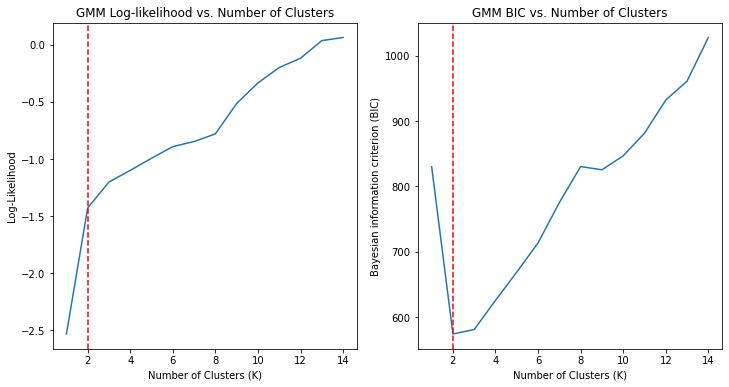

In [7]:
## Solution ##
Ks = np.arange(1, 15, 1)
lls = []
bics = []
for K in Ks:
    gm = GaussianMixture(n_components=K, random_state=0).fit(X_iris)
    ll = gm.score(X_iris)
    bic = gm.bic(X_iris)
    lls.append(ll)
    bics.append(bic)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.ravel()
ax[0].plot(Ks, lls)
ax[0].set_ylabel('Log-Likelihood')
ax[0].set_xlabel('Number of Clusters (K)')
ax[0].set_title('GMM Log-likelihood vs. Number of Clusters')
ax[0].axvline(Ks[np.argmin(bics)], c='r', ls='--')
ax[1].plot(Ks, bics)
ax[1].set_ylabel('Bayesian information criterion (BIC)')
ax[1].set_xlabel('Number of Clusters (K)')
ax[1].set_title('GMM BIC vs. Number of Clusters')
ax[1].axvline(Ks[np.argmin(bics)], c='r', ls='--')


Log-likelihood is a measure of the joint probability of the observed data as a function of the parameters of the chosen statistical model. As more clusters are added to the GMM, this measure will rise until every data point represents a mean vector defining a gaussian with zero covariance. The product of these probabilities for each data point will achieve the largest possible log-likelihood. BIC depends on the log-likelihood so will likewise rise with the number of parameters, but at a different rate due to the penalty term favoring parsimonious models (with few clusters).

Based on the results, the best number of clusters is 2. This corresponds to where BIC is minimized and where an "elbow" occurs in the log-likelihood curve.

With each added feature, a dimension is added to the average vectors and covariance matrices describing each multivariate gaussian component. With each new cluster, a new average vector and covariance matrix is added to the model.